In [487]:
# (Optionnel) Installer mord dans l'environnement du kernel Jupyter
# Si mord est déjà installé, cette cellule ne fait rien.

import importlib.util, sys

if importlib.util.find_spec("mord") is None:
    !{sys.executable} -m pip install mord
else:
    print("mord déjà installé ✅")


mord déjà installé ✅


# Prédiction de la consommation (conso_5_usages_ef) via **régression logistique ordinale**

Objectif : prédire une **consommation estimée** à partir des caractéristiques du logement, en utilisant une **régression logistique ordinale**.

Comme l’ordinal logit prédit des **classes ordonnées**, on procède en 3 étapes :
1. Discrétiser la conso en **K bins ordonnés** (calculés **sur le train uniquement**).
2. Apprendre un modèle **ordinal logit** sur ces classes.
3. Reconstruire une conso continue via une valeur **robuste par classe** (médiane par bin, côté train).


In [488]:
# =========================
# Paramètres du modèle
# =========================
# K = nombre de bins (classes ordinales). Ex: 5 / 7 / 10
# alpha = régularisation du modèle ordinal (mord.LogisticAT)
K = 12 # utilise le paramètre défini plus haut
ALPHA = 0.3

RANDOM_SEED = 42


In [489]:
import pandas as pd
import numpy as np
import mord

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from pathlib import Path

# --- Chargement du dataset (chemin robuste) ---
csv_path = Path("../../data/features/DPE.csv")

if not csv_path.exists():
    # aide debug si le notebook est lancé depuis un autre dossier
    import os
    raise FileNotFoundError(
        f"CSV introuvable: {csv_path.resolve()}\n"
        f"cwd = {os.getcwd()}\n"
        f"Astuce: ajuste le chemin vers data/processed/DPE.csv"
    )

df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)


Dataset shape: (8700, 14)


In [490]:
# Target
TARGET = "conso_finale"

if TARGET not in df.columns:
    # debug utile
    cols_like = [c for c in df.columns if "conso" in c.lower()]
    raise ValueError(f"Target '{TARGET}' introuvable. Colonnes conso: {cols_like[:50]}")

y = pd.to_numeric(df[TARGET], errors="coerce")


# Colonnes à exclure (anti-fuite + anti-mémorisation)
leak_cols = [
    # Labels / sorties dérivées de la performance
    #"etiquette_dpe",
    #"etiquette_ges",

    # # Autres sorties perf très corrélées (à exclure)
    #"conso_primaire",
    #"cout_conso",
    "code_postal",
    "type_energie_principale",
    # # La target (EXCLUSION OBLIGATOIRE)
    TARGET,
]

# garde uniquement celles qui existent vraiment dans le CSV
leak_cols = [c for c in leak_cols if c in df.columns]

In [491]:
# Construction de X (sans fuite) + filtrage des y manquants

X = df.drop(columns=[c for c in leak_cols if c in df.columns], errors="ignore")

mask = y.notna()
X = X.loc[mask].copy()
y = y.loc[mask].copy()


# Split train/test/validation (70% train, 15% test, 15% validation)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape, "Val:", X_val.shape)

# Détection num/cat (à partir du train)
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns


Train: (6090, 11) Test: (1305, 11) Val: (1305, 11)


In [492]:
# Prétraitement (dense car HGBR n'accepte pas sparse)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ]), num_cols),

        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe),
        ]), cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.0  # force sortie dense globale
)

Xtr = preprocess.fit_transform(X_train)
Xte = preprocess.transform(X_test)
Xva = preprocess.transform(X_val)

print("Xtr:", Xtr.shape, "Xte:", Xte.shape, "Xva:", Xva.shape)


Xtr: (6090, 31) Xte: (1305, 31) Xva: (1305, 31)


In [493]:
# Choix du nombre de classes ordinales
K = K  # utilise le paramètre défini plus haut
# Binning sur TRAIN uniquement (quantiles) -> pas de fuite
y_train_cls, bin_edges = pd.qcut(
    y_train, q=K, labels=False, retbins=True, duplicates="drop"
)
y_train_cls = y_train_cls.astype(int)

# Appliquer les mêmes bornes sur test/val
y_test_cls = pd.cut(y_test, bins=bin_edges, labels=False, include_lowest=True)
y_val_cls  = pd.cut(y_val,  bins=bin_edges, labels=False, include_lowest=True)

# Filtrer les NaN éventuels (valeurs hors bornes, rare)
test_mask = ~y_test_cls.isna()
val_mask  = ~y_val_cls.isna()

Xte2 = Xte[test_mask.values]
y_test2 = y_test.loc[test_mask].copy()
y_test_cls = y_test_cls.loc[test_mask].astype(int)

Xva2 = Xva[val_mask.values]
y_val2 = y_val.loc[val_mask].copy()
y_val_cls = y_val_cls.loc[val_mask].astype(int)

print("Bins réellement utilisés:", len(bin_edges)-1)
print("Test kept:", len(y_test2), "Val kept:", len(y_val2))

# Reconstruction continue robuste: médiane par classe (sur train)
train_bins = pd.cut(y_train, bins=bin_edges, labels=False, include_lowest=True)
class_median = y_train.groupby(train_bins).median().values  # taille = nb_bins

# Modèle ordinal logit
ord_model = mord.LogisticAT(alpha=ALPHA)  # alpha défini dans Paramètres  # alpha = régularisation (à tuner)
ord_model.fit(Xtr, y_train_cls)

# Prédiction classes
cls_pred_test = ord_model.predict(Xte2)
cls_pred_val  = ord_model.predict(Xva2)

# Prédiction conso (continue) via médiane de bin
y_pred_test = class_median[cls_pred_test]
y_pred_val  = class_median[cls_pred_val]

Bins réellement utilisés: 12
Test kept: 1304 Val kept: 1305


In [494]:
def eval_reg(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} MAE  = {mae:.2f}")
    print(f"{name} RMSE = {rmse:.2f}")
    print(f"{name} R²   = {r2:.3f}")
    return mae, rmse, r2

print("=== Ordinal logit sur conso binned ===")
print("TARGET:", TARGET)
print("K bins:", len(bin_edges)-1)

print("\n--- Régression (reconstruction continue) ---")
eval_reg(y_test2, y_pred_test, name="TEST")
eval_reg(y_val2,  y_pred_val,  name="VAL ")

print("\n--- Ordinal (qualité de classement) ---")
mae_rank_test = np.mean(np.abs(y_test_cls.values - cls_pred_test))
acc_pm1_test  = np.mean(np.abs(y_test_cls.values - cls_pred_test) <= 1)

mae_rank_val = np.mean(np.abs(y_val_cls.values - cls_pred_val))
acc_pm1_val  = np.mean(np.abs(y_val_cls.values - cls_pred_val) <= 1)

print(f"TEST MAE rang  = {mae_rank_test:.3f}")
print(f"TEST Acc ±1    = {acc_pm1_test:.3f}")
print(f"VAL  MAE rang  = {mae_rank_val:.3f}")
print(f"VAL  Acc ±1    = {acc_pm1_val:.3f}")

print("\n--- Détails bins ---")
print("bin_edges:", bin_edges)
print("class_median:", class_median)


=== Ordinal logit sur conso binned ===
TARGET: conso_finale
K bins: 12

--- Régression (reconstruction continue) ---
TEST MAE  = 2442.63
TEST RMSE = 5006.37
TEST R²   = 0.841
VAL  MAE  = 2371.18
VAL  RMSE = 4728.80
VAL  R²   = 0.852

--- Ordinal (qualité de classement) ---
TEST MAE rang  = 0.526
TEST Acc ±1    = 0.933
VAL  MAE rang  = 0.522
VAL  Acc ±1    = 0.930

--- Détails bins ---
bin_edges: [   619.1          3085.975        4158.58333333   5187.45
   6579.16666667   8109.24166667   9985.6         11972.56666667
  14586.86666667  18137.025       23622.48333333  33307.85
 139319.9       ]
class_median: [ 2468.95  3603.6   4668.7   5842.9   7291.05  8999.7  10862.3  13047.45
 16304.4  20603.6  27422.9  44072.3 ]


## Lecture des résultats (affichage clair)

Ce bloc affiche :
- **métriques régression reconstruite** (MAE / RMSE / R²) : comparaison de la conso vraie vs conso reconstruite à partir de la classe prédite  
- **métriques ordinales** (MAE rang / Acc ±1) : qualité du classement en bins (0…K−1)  
- **baseline** : prédire la médiane du train (référence "modèle nul")
- des **plots** pour visualiser : vrai vs prédit, résidus, et matrice de confusion des classes ordinales.


=== Comment lire les résultats ===
- Régression reconstruite : on prédit une CLASSE (bin), puis on reconstruit une conso continue (médiane du bin).
  → MAE/RMSE/R² évaluent cette conso reconstruite (valeur continue).
- Ordinal pur : on évalue directement la CLASSE prédite.
  → MAE rang = |classe vraie - classe prédite| ; Acc ±1 = % à 1 classe près.

=== Tableau de résultats ===


,Split,Model,MAE,RMSE,R2,MAE_rang,MAE_rang_norm,Acc_pm1
0,TEST,Baseline (médiane),8284.630138,13221.840630,-0.109160,NaN,NaN,NaN
1,TEST,Ordinal (reconstruit),2442.634739,5006.367060,0.840978,0.526074,0.047825,0.933282
2,VAL,Baseline (médiane),8466.637318,12843.057862,-0.092243,NaN,NaN,NaN
3,VAL,Ordinal (reconstruit),2371.181954,4728.799582,0.851924,0.521839,0.047440,0.930268



=== Bins utilisés (définis sur TRAIN) ===


,bin,lower,upper,train_count,class_median
0,0,619.100000,3085.975000,508,2468.95
1,1,3085.975000,4158.583333,507,3603.60
2,2,4158.583333,5187.450000,508,4668.70
3,3,5187.450000,6579.166667,507,5842.90
4,4,6579.166667,8109.241667,508,7291.05
5,5,8109.241667,9985.600000,507,8999.70
6,6,9985.600000,11972.566667,507,10862.30
7,7,11972.566667,14586.866667,508,13047.45
8,8,14586.866667,18137.025000,507,16304.40
9,9,18137.025000,23622.483333,508,20603.60


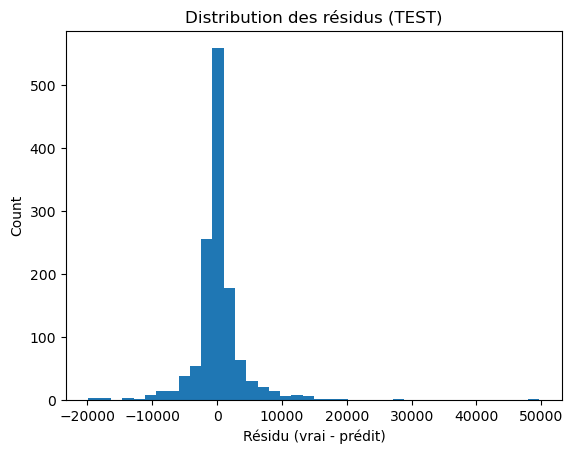

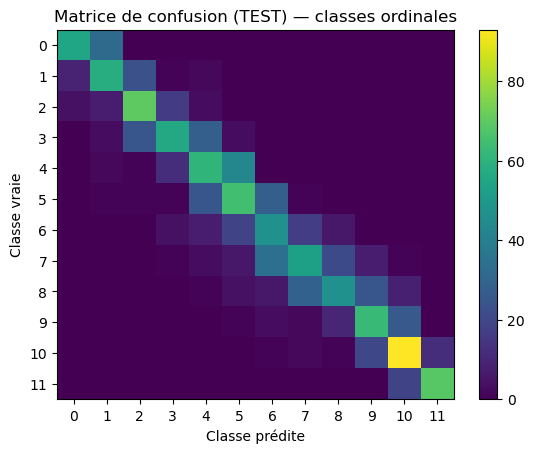

<Figure size 640x480 with 0 Axes>

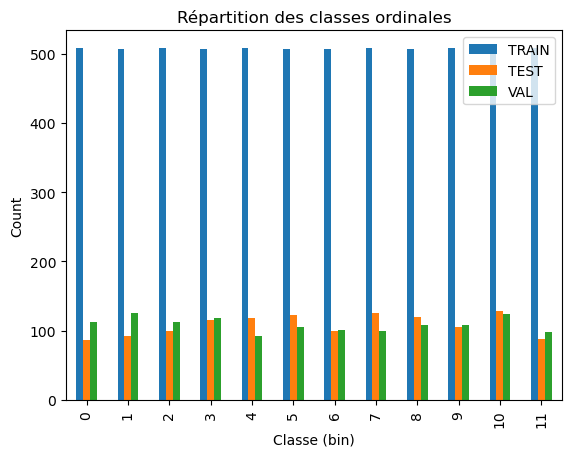

In [495]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.metrics import confusion_matrix, mean_absolute_error, r2_score

# ---------- 0) Sécurité : vérifier que les variables clés existent ----------
required = [
    "K", "bin_edges", "class_median",
    "y_train", "y_test2", "y_pred_test", "y_val2", "y_pred_val",
    "y_test_cls", "cls_pred_test", "y_val_cls", "cls_pred_val",
]
missing = [v for v in required if v not in globals()]
if missing:
    print("Variables manquantes :", missing)
    print("→ Relance les cellules du notebook dans l'ordre (de haut en bas).")
else:
    # ---------- 1) Rappel : que signifient les deux familles de métriques ? ----------
    print("=== Comment lire les résultats ===")
    print("- Régression reconstruite : on prédit une CLASSE (bin), puis on reconstruit une conso continue (médiane du bin).")
    print("  → MAE/RMSE/R² évaluent cette conso reconstruite (valeur continue).")
    print("- Ordinal pur : on évalue directement la CLASSE prédite.")
    print("  → MAE rang = |classe vraie - classe prédite| ; Acc ±1 = % à 1 classe près.")
    print()

    # ---------- 2) Baseline (modèle nul) ----------
    y_pred_base_test = np.full_like(y_test2.values, y_train.median(), dtype=float)
    y_pred_base_val  = np.full_like(y_val2.values,  y_train.median(), dtype=float)

    # ---------- 3) Tableau métriques (TEST / VAL) ----------
    def rmse_np(y_true, y_pred):
        return np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2))

    def metrics_reg(y_true, y_pred):
        return {
            "MAE": float(mean_absolute_error(y_true, y_pred)),
            "RMSE": float(rmse_np(y_true, y_pred)),
            "R2": float(r2_score(y_true, y_pred)),
        }

    def metrics_ord(y_cls_true, y_cls_pred, K):
        err = np.abs(np.asarray(y_cls_true) - np.asarray(y_cls_pred))
        return {
            "MAE_rang": float(np.mean(err)),
            "MAE_rang_norm": float(np.mean(err) / max(K-1, 1)),
            "Acc_pm1": float(np.mean(err <= 1)),
        }

    rows = []
    rows.append({"Split":"TEST", "Model":"Baseline (médiane)", **metrics_reg(y_test2, y_pred_base_test)})
    rows.append({"Split":"TEST", "Model":"Ordinal (reconstruit)", **metrics_reg(y_test2, y_pred_test), **metrics_ord(y_test_cls, cls_pred_test, K)})

    rows.append({"Split":"VAL", "Model":"Baseline (médiane)", **metrics_reg(y_val2, y_pred_base_val)})
    rows.append({"Split":"VAL", "Model":"Ordinal (reconstruit)", **metrics_reg(y_val2, y_pred_val), **metrics_ord(y_val_cls, cls_pred_val, K)})

    metrics_df = pd.DataFrame(rows)

    # mise en forme légère
    display_cols = ["Split","Model","MAE","RMSE","R2","MAE_rang","MAE_rang_norm","Acc_pm1"]
    metrics_df = metrics_df.reindex(columns=[c for c in display_cols if c in metrics_df.columns])

    print("=== Tableau de résultats ===")
    display(metrics_df)

    # ---------- 4) Tableau des bins (bornes + médiane + effectif train) ----------
    train_bins = pd.cut(y_train, bins=bin_edges, labels=False, include_lowest=True)
    counts = train_bins.value_counts().sort_index()
    bins_df = pd.DataFrame({
        "bin": np.arange(len(bin_edges)-1),
        "lower": bin_edges[:-1],
        "upper": bin_edges[1:],
        "train_count": [int(counts.get(i, 0)) for i in range(len(bin_edges)-1)],
        "class_median": class_median,
    })
    print("\n=== Bins utilisés (définis sur TRAIN) ===")
    display(bins_df)

    # ---------- 5) Plots ----------
    # 5.2 Résidus (TEST)
    residuals = np.asarray(y_test2) - np.asarray(y_pred_test)
    plt.figure()
    plt.hist(residuals, bins=40)
    plt.xlabel("Résidu (vrai - prédit)")
    plt.ylabel("Count")
    plt.title("Distribution des résidus (TEST)")
    plt.show()

    # 5.3 Matrice de confusion ordinal (TEST)
    cm = confusion_matrix(y_test_cls, cls_pred_test, labels=list(range(K)))
    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.colorbar()
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe vraie")
    plt.title("Matrice de confusion (TEST) — classes ordinales")
    plt.xticks(range(K))
    plt.yticks(range(K))
    plt.show()

    # 5.4 Répartition des classes (TRAIN/TEST/VAL)
    # (pratique pour voir déséquilibre / difficulté par classe)
    y_test_cls_full = pd.cut(y_test, bins=bin_edges, labels=False, include_lowest=True)
    y_val_cls_full  = pd.cut(y_val,  bins=bin_edges, labels=False, include_lowest=True)

    def dist_series(s, K):
        s = pd.Series(s).dropna().astype(int)
        return pd.Series([int((s==i).sum()) for i in range(K)], index=range(K))

    dist = pd.DataFrame({
        "TRAIN": dist_series(train_bins, K),
        "TEST":  dist_series(y_test_cls_full, K),
        "VAL":   dist_series(y_val_cls_full, K),
    })
    plt.figure()
    dist.plot(kind="bar")
    plt.xlabel("Classe (bin)")
    plt.ylabel("Count")
    plt.title("Répartition des classes ordinales")
    plt.show()



## Sélection automatique de K et alpha (ordinal logit)

**Pourquoi K existe ?**  
La régression logistique ordinale ne prédit pas une valeur continue directement : elle prédit une **classe ordonnée** (0…K−1).  
Ici, `K` = **nombre de tranches (bins)** dans lesquelles on découpe la consommation `conso_5_usages_ef`.

- **K petit** (ex. 5–7) : classes plus larges → **plus facile** de bien classer (meilleures métriques ordinales), mais la conso reconstruite est plus “en paliers” (moins précise).
- **K grand** (ex. 10–15) : classes plus fines → meilleure quantification potentielle (conso reconstruite plus précise), mais **classement plus dur** (métriques ordinales ±1 baissent souvent).

On choisit donc K en optimisant une métrique **continue** (MAE/RMSE/R² sur la conso reconstruite) et/ou une métrique **ordinal** (MAE rang / Acc ±1).


In [496]:

import numpy as np
import pandas as pd
import mord
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_pack(y_true_cont, y_pred_cont, y_true_cls, y_pred_cls, K):
    out = {}
    out["mae"] = float(mean_absolute_error(y_true_cont, y_pred_cont))
    out["rmse"] = rmse(y_true_cont, y_pred_cont)
    out["r2"] = float(r2_score(y_true_cont, y_pred_cont))
    out["mae_rank"] = float(np.mean(np.abs(y_true_cls - y_pred_cls)))
    out["acc_pm1"] = float(np.mean(np.abs(y_true_cls - y_pred_cls) <= 1))
    out["mae_rank_norm"] = out["mae_rank"] / max(K-1, 1)
    return out

# Grille à tester
K_list = [5, 7, 10, 12, 15]
alpha_list = [0.1,0.2, 0.3,0.4,0.5, 1.0]

rows = []

# Prérequis attendus dans le notebook (déjà calculés plus haut) :
# - Xtr, Xte, Xva (matrices preprocess)
# - y_train, y_test, y_val (cibles continues)
# - y_test2, y_val2 (cibles continues filtrées si besoin)
# - preprocess déjà fit sur train (dans ce notebook, Xtr/Xte/Xva existent déjà)
# Ici, on refait seulement le binning + entraînement ordinal.

for K in K_list:
    # Binning sur TRAIN uniquement
    y_train_cls, bin_edges = pd.qcut(y_train, q=K, labels=False, retbins=True, duplicates="drop")
    y_train_cls = y_train_cls.astype(int)

    # Appliquer bornes sur test/val
    y_test_cls = pd.cut(y_test, bins=bin_edges, labels=False, include_lowest=True)
    y_val_cls  = pd.cut(y_val,  bins=bin_edges, labels=False, include_lowest=True)

    # Filtrage NaN éventuels
    test_mask = ~y_test_cls.isna()
    val_mask  = ~y_val_cls.isna()

    Xte2 = Xte[test_mask.values]
    Xva2 = Xva[val_mask.values]

    y_test2 = y_test.loc[test_mask].copy()
    y_val2  = y_val.loc[val_mask].copy()

    y_test_cls2 = y_test_cls.loc[test_mask].astype(int).values
    y_val_cls2  = y_val_cls.loc[val_mask].astype(int).values

    # Reconstruction continue: médiane par classe (train)
    train_bins = pd.cut(y_train, bins=bin_edges, labels=False, include_lowest=True)
    class_median = y_train.groupby(train_bins).median().values  # taille = nb_bins réels

    K_real = len(class_median)

    for alpha in alpha_list:
        model = mord.LogisticAT(alpha=alpha)
        model.fit(Xtr, y_train_cls)

        cls_pred_test = model.predict(Xte2)
        cls_pred_val  = model.predict(Xva2)

        # Conso reconstruite
        y_pred_test = class_median[cls_pred_test]
        y_pred_val  = class_median[cls_pred_val]

        test_metrics = eval_pack(y_test2.values, y_pred_test, y_test_cls2, cls_pred_test, K_real)
        val_metrics  = eval_pack(y_val2.values,  y_pred_val,  y_val_cls2,  cls_pred_val,  K_real)

        rows.append({
            "K": K_real,
            "alpha": alpha,
            "TEST_MAE": test_metrics["mae"],
            "TEST_RMSE": test_metrics["rmse"],
            "TEST_R2": test_metrics["r2"],
            "TEST_MAE_rank": test_metrics["mae_rank"],
            "TEST_Acc_pm1": test_metrics["acc_pm1"],
            "VAL_MAE": val_metrics["mae"],
            "VAL_RMSE": val_metrics["rmse"],
            "VAL_R2": val_metrics["r2"],
            "VAL_MAE_rank": val_metrics["mae_rank"],
            "VAL_Acc_pm1": val_metrics["acc_pm1"],
        })

results = pd.DataFrame(rows).sort_values(["VAL_MAE", "VAL_RMSE", "VAL_R2"], ascending=[True, True, False])

print("Top 10 (trié sur VAL_MAE puis VAL_RMSE)")
display(results.head(10))

best = results.iloc[0]
print("\nMeilleur candidat (selon VAL_MAE):")
print(best.to_string())


Top 10 (trié sur VAL_MAE puis VAL_RMSE)


,K,alpha,TEST_MAE,TEST_RMSE,TEST_R2,TEST_MAE_rank,TEST_Acc_pm1,VAL_MAE,VAL_RMSE,VAL_R2,VAL_MAE_rank,VAL_Acc_pm1
20,12,0.3,2442.634739,5006.367060,0.840978,0.526074,0.933282,2371.181954,4728.799582,0.851924,0.521839,0.930268
18,12,0.1,2547.676112,5235.975627,0.826057,0.512270,0.937117,2465.740881,4847.833255,0.844376,0.526437,0.922605
24,15,0.1,2536.600077,4957.615740,0.844060,0.704755,0.872699,2472.158429,4625.475618,0.858324,0.723372,0.861303
22,12,0.5,2597.027799,5198.218688,0.828557,0.536810,0.922546,2488.714330,4843.506579,0.844653,0.527203,0.918008
25,15,0.2,2644.205560,5094.991406,0.835299,0.733896,0.848926,2492.305517,4689.950643,0.854347,0.728736,0.842146
21,12,0.4,2596.264762,5167.774843,0.830559,0.555215,0.921779,2504.226590,4835.311335,0.845179,0.537931,0.921073
27,15,0.4,2637.815031,5032.775818,0.839296,0.760736,0.848926,2524.844674,4693.726146,0.854113,0.763218,0.842146
17,10,1.0,2769.925844,5538.824524,0.805354,0.453221,0.947853,2570.790575,5024.540919,0.832824,0.439080,0.954789
14,10,0.3,2634.566258,5467.200241,0.810355,0.424080,0.956288,2571.983985,5055.036659,0.830788,0.442146,0.955556
12,10,0.1,2637.545782,5485.011933,0.809118,0.421779,0.957055,2574.395709,5090.023232,0.828438,0.442912,0.954023



Meilleur candidat (selon VAL_MAE):
K                  12.000000
alpha               0.300000
TEST_MAE         2442.634739
TEST_RMSE        5006.367060
TEST_R2             0.840978
TEST_MAE_rank       0.526074
TEST_Acc_pm1        0.933282
VAL_MAE          2371.181954
VAL_RMSE         4728.799582
VAL_R2              0.851924
VAL_MAE_rank        0.521839
VAL_Acc_pm1         0.930268


In [560]:
import numpy as np
import pandas as pd

# --- Choisir une ligne aléatoire dans le TEST (sur les mêmes indices que y_test) ---
rng = np.random.default_rng()

# Si tu as filtré y_test via test_mask (y_test2), prends les indices de y_test2 :
idx = rng.choice(y_test2.index)

x_row = X.loc[idx:idx]          # 1 ligne, format DataFrame (important)
y_true = float(y.loc[idx])      # conso vraie

# --- Transformer + prédire classe ---
Xu = preprocess.transform(x_row)
cls_pred = int(ord_model.predict(Xu)[0])

# --- Reconstruire conso prédite (médiane du bin) ---
cls_pred = int(np.clip(cls_pred, 0, len(class_median) - 1))
y_pred = float(class_median[cls_pred])

# --- (Optionnel) classe vraie selon tes bins (pour debug) ---
y_true_cls = pd.cut(pd.Series([y_true]), bins=bin_edges, labels=False, include_lowest=True).iloc[0]
y_true_cls = None if pd.isna(y_true_cls) else int(y_true_cls)

print("=== Démo prédiction sur une ligne aléatoire (TEST) ===")
print("Index:", idx)
print(f"Conso vraie   : {y_true:.2f}")
print(f"Conso prédite : {y_pred:.2f}")
print(f"Erreur (abs)  : {abs(y_true - y_pred):.2f}")
print(f"Erreur de prediction en pourcentage : {abs(y_true - y_pred) / max(abs(y_true), 1e-9) * 100:.2f}%")
print(f"Classe prédite: {cls_pred}")
print(f"Classe vraie  : {y_true_cls}")


print("\n--- Extrait des caractéristiques (10 premières valeurs non nulles) ---")
s = x_row.iloc[0].dropna()
print(s.head(24).to_string())


=== Démo prédiction sur une ligne aléatoire (TEST) ===
Index: 1219
Conso vraie   : 4938.00
Conso prédite : 4158.55
Erreur (abs)  : 779.45
Erreur de prediction en pourcentage : 15.78%
Classe prédite: 2
Classe vraie  : 3

--- Extrait des caractéristiques (10 premières valeurs non nulles) ---
type_batiment                  appartement
type_installation_chauffage     individuel
type_installation_ecs           individuel
hauteur_sous_plafond                   2.5
etiquette_dpe                            C
etiquette_ges                            A
surface_habitable_logement            63.5
nombre_niveau_logement                 1.0
isolation                          moyenne
cout_conso                           896.8
conso_primaire                     11357.4


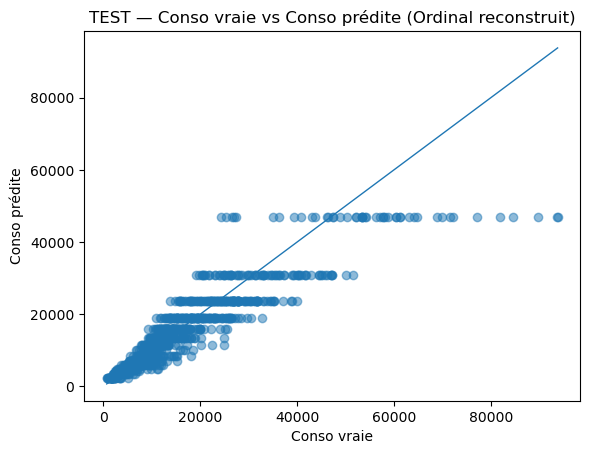

In [498]:
# On va prédire sur les données de Test la conso prédite sur la conso vrai et on affiche ça dans un graph 

import numpy as np
import matplotlib.pyplot as plt

y_true = np.asarray(y_test2, dtype=float)
y_pred = np.asarray(y_pred_test, dtype=float)

# Scatter : vrai vs prédit
plt.figure()
plt.scatter(y_true, y_pred, alpha=0.5)

# Diagonale parfaite y = x
min_v = np.nanmin([y_true.min(), y_pred.min()])
max_v = np.nanmax([y_true.max(), y_pred.max()])
plt.plot([min_v, max_v], [min_v, max_v], linewidth=1)

plt.xlabel("Conso vraie")
plt.ylabel("Conso prédite")
plt.title("TEST — Conso vraie vs Conso prédite (Ordinal reconstruit)")
plt.show()



In [561]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

pipe_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("model", HistGradientBoostingRegressor(random_state=42)),
])

pipe_reg.fit(X_train, y_train)

pred_reg_test = pipe_reg.predict(X_test)
pred_reg_val  = pipe_reg.predict(X_val)

def eval_reg(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))  # compatible toutes versions sklearn
    r2 = r2_score(y_true, y_pred)
    print(f"{name} MAE  = {mae:.2f}")
    print(f"{name} RMSE = {rmse:.2f}")
    print(f"{name} R²   = {r2:.3f}")
    return mae, rmse, r2

print("\n=== Régression continue (sans K) ===")
eval_reg(y_test, pred_reg_test, "TEST")
eval_reg(y_val,  pred_reg_val,  "VAL ")


c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\rapha\Documents\Cours2024_25\MachineLearning\f1-ml-project\.conda\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fd


=== Régression continue (sans K) ===
TEST MAE  = 1047.42
TEST RMSE = 2189.92
TEST R²   = 0.970
VAL  MAE  = 1060.35
VAL  RMSE = 2352.40
VAL  R²   = 0.963


(1060.345465392933, 2352.4008359472496, 0.9633558291143484)

In [563]:
import pandas as pd
import numpy as np
import mord

K = 12          # à tester
ALPHA = 0.3    # à tuner

# Bins sur TRAIN uniquement (pas de fuite)
y_train_cls, bin_edges = pd.qcut(y_train, q=K, labels=False, retbins=True, duplicates="drop")
y_train_cls = y_train_cls.astype(int)

# Appliquer les mêmes bornes sur test/val
y_test_cls = pd.cut(y_test, bins=bin_edges, labels=False, include_lowest=True)
y_val_cls  = pd.cut(y_val,  bins=bin_edges, labels=False, include_lowest=True)

# Filtrer les NaN (si hors bornes, rare)
test_mask = ~y_test_cls.isna()
val_mask  = ~y_val_cls.isna()

X_test_cls = X_test.loc[test_mask].copy()
X_val_cls  = X_val.loc[val_mask].copy()
y_test_cls = y_test_cls.loc[test_mask].astype(int)
y_val_cls  = y_val_cls.loc[val_mask].astype(int)

# Transform via preprocess
Xtr = preprocess.fit_transform(X_train)
Xte = preprocess.transform(X_test_cls)
Xva = preprocess.transform(X_val_cls)

ord_model = mord.LogisticAT(alpha=ALPHA)
ord_model.fit(Xtr, y_train_cls)

pred_cls_test = ord_model.predict(Xte)
pred_cls_val  = ord_model.predict(Xva)

def eval_cls(y_true_cls, y_pred_cls, name=""):
    mae_rank = float(np.mean(np.abs(y_true_cls.values - y_pred_cls)))
    acc_pm1  = float(np.mean(np.abs(y_true_cls.values - y_pred_cls) <= 1))
    acc      = float(np.mean(y_true_cls.values == y_pred_cls))
    print(f"{name} Acc        = {acc:.3f}")
    print(f"{name} Acc ±1     = {acc_pm1:.3f}")
    print(f"{name} MAE rang   = {mae_rank:.3f}")
    return acc, acc_pm1, mae_rank

print("\n=== Classification ordinale (avec K) ===")
print(f"K bins réels = {len(bin_edges)-1}")
eval_cls(y_test_cls, pred_cls_test, "TEST")
eval_cls(y_val_cls,  pred_cls_val,  "VAL ")



=== Classification ordinale (avec K) ===
K bins réels = 12
TEST Acc        = 0.565
TEST Acc ±1     = 0.933
TEST MAE rang   = 0.526
VAL  Acc        = 0.572
VAL  Acc ±1     = 0.930
VAL  MAE rang   = 0.522


(0.5724137931034483, 0.9302681992337165, 0.5218390804597701)

In [673]:
import numpy as np
import pandas as pd

rng = np.random.default_rng()
idx = rng.choice(X_test.index)     # ligne random dans TEST

x_row = X.loc[idx:idx]
y_true = float(y.loc[idx])

# Régression continue
y_pred_reg = float(pipe_reg.predict(x_row)[0])

# Classe vraie/pred (attention: on applique les bins du train)
y_true_cls = pd.cut(pd.Series([y_true]), bins=bin_edges, labels=False, include_lowest=True).iloc[0]
y_true_cls = None if pd.isna(y_true_cls) else int(y_true_cls)

Xu = preprocess.transform(x_row)
y_pred_cls = int(ord_model.predict(Xu)[0])

print("=== Démo (1 ligne du TEST) ===")
print("Index:", idx)
print(f"Conso vraie             : {y_true:.2f}")
print(f"Conso prédite (régr.)   : {y_pred_reg:.2f}")
print(f"Erreur % (régr.)        : {abs(y_true - y_pred_reg) / max(abs(y_true), 1e-9) * 100:.2f}%")
print(f"Classe vraie (bins)     : {y_true_cls}")
print(f"Classe prédite (ordinal): {y_pred_cls}")

print("\n--- Extrait des caractéristiques (15 premières non nulles) ---")
s = x_row.iloc[0].dropna()
print(s.head(15).to_string())


=== Démo (1 ligne du TEST) ===
Index: 8108
Conso vraie             : 16403.30
Conso prédite (régr.)   : 16403.45
Erreur % (régr.)        : 0.00%
Classe vraie (bins)     : 8
Classe prédite (ordinal): 8

--- Extrait des caractéristiques (15 premières non nulles) ---
type_batiment                      maison
type_installation_chauffage    individuel
type_installation_ecs          individuel
hauteur_sous_plafond                  2.5
etiquette_dpe                           E
etiquette_ges                           B
surface_habitable_logement           96.5
nombre_niveau_logement                1.0
isolation                         moyenne
cout_conso                         1729.0
conso_primaire                    29911.2


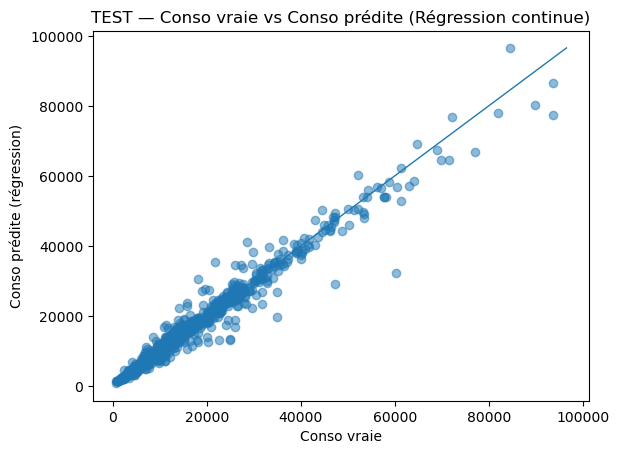

In [655]:
import numpy as np
import matplotlib.pyplot as plt

y_true = np.asarray(y_test, dtype=float)
y_pred = np.asarray(pred_reg_test, dtype=float)

plt.figure()
plt.scatter(y_true, y_pred, alpha=0.5)

min_v = np.nanmin([y_true.min(), y_pred.min()])
max_v = np.nanmax([y_true.max(), y_pred.max()])
plt.plot([min_v, max_v], [min_v, max_v], linewidth=1)

plt.xlabel("Conso vraie")
plt.ylabel("Conso prédite (régression)")
plt.title("TEST — Conso vraie vs Conso prédite (Régression continue)")
plt.show()

